# Testing How Best To Determine Point Removal

In [62]:
import os
import tsplib95
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import signal
import tqdm
from multiprocess import Pool
import matplotlib.pyplot as plt
from matplotlib.colors import *


from wsp import tsp, ds

FILE_DIR = "DATA_GEN_20p0.25"
AX = np.array([None, None])
S_FACTOR = 8.0
TREE_TYPE = ds.PKPRQuadTree

In [63]:
top_problems = sorted(os.listdir(FILE_DIR))

len(top_problems)

5000

## Problem Injestion

In [64]:
base_df = pd.DataFrame(columns=['name', 'parent', 'path_reduction', 'wsp_reduction', 'point_specific_wsp', 'point_specific_wsp_weighted'])
base_df = base_df.astype({'name': str, 'parent': str, 'path_reduction': float, 'wsp_reduction': float, 'point_specific_wsp': float, 'point_specific_wsp_weighted': float})
base_df.set_index('name', inplace=True)

In [65]:
removed_problems : list[tsplib95.models.StandardProblem] = []
def setup(top_problem):
    main_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{top_problem}.tsp")
    main_conc_cost = float(main_problem.comment.split(' ')[2])
    main_points = [ds.Point(*main_problem.node_coords[i]) for i in main_problem.get_nodes()]
    main_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, main_points, AX, s=S_FACTOR)
    main_cost = main_problem_object.calc_dist(
        [main_points[i-1] for i in main_problem.tours[0]] + [main_points[main_problem.tours[0][0] - 1]]
    )

    updates = base_df.copy()
    for removal_name in os.listdir(f"{FILE_DIR}/{top_problem}"):
        if '_' not in removal_name: continue
        point_number = int(removal_name.split('_')[-1].split('.')[0]) # number of the missing point in the og

        sub_problem = tsplib95.load(f"{FILE_DIR}/{top_problem}/{removal_name}")
        sub_conc_cost = float(sub_problem.comment.split(' ')[2])
        sub_points = [ds.Point(*sub_problem.node_coords[i]) for i in sub_problem.get_nodes()]
        sub_problem_object = tsp.TravellingSalesmanProblem[TREE_TYPE](TREE_TYPE, sub_points, AX, s=S_FACTOR)
        sub_cost = sub_problem_object.calc_dist(
            [sub_points[i-1] for i in sub_problem.tours[0]] + [sub_points[sub_problem.tours[0][0] - 1]]
        )

        point_specific_wsp = sum(
            len(connections) if main_points[point_number - 1] in tree else 0
            for tree, connections in main_problem_object.single_indexable_wspd.items()
        )
        
        updates.loc[sub_problem.name] = {
            'parent': top_problem,
            'path_reduction': sub_conc_cost / main_conc_cost, 
            'wsp_reduction': len(sub_problem_object.wspd) / len(main_problem_object.wspd),
            'point_specific_wsp': point_specific_wsp,
            'point_specific_wsp_weighted': point_specific_wsp / len(main_problem_object.wspd)
        }
    return updates

original_sigint_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)
pool = Pool(6) # NUMBER OF PROCESSES
signal.signal(signal.SIGINT, original_sigint_handler)

update_collection = []
u=0
try:
    with tqdm.tqdm(total=len(top_problems), unit="top problem") as pbar:
        for result in pool.imap_unordered(setup, top_problems):
            update_collection.append(result)
            pbar.update(1)
            prob_name = next(iter(result))
            u += 1
            # if result[prob_name] != {}:
            #     u += 1
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name, "last_updated": prob_name, "updated": u}})
            # else:
            #     # pbar.set_postfix(pf := {**pf, **{"last": prob_name}})
except KeyboardInterrupt:
    print("Caught KeyboardInterrupt, terminating workers")
    pool.terminate()
else:
    pool.close()
pool.join()

print("Injesting updates")
reduction_df = pd.concat(update_collection)
reduction_df

100%|██████████| 5000/5000 [00:43<00:00, 114.39top problem/s]


Injesting updates


,parent,path_reduction,wsp_reduction,point_specific_wsp,point_specific_wsp_weighted
name,,,,,
aaf20p0.25_6,aaf20p0.25,1.000000,0.975309,18,0.222222
aaf20p0.25_16,aaf20p0.25,0.929619,0.839506,9,0.111111
aaf20p0.25_17,aaf20p0.25,0.920021,0.901235,9,0.111111
aaf20p0.25_7,aaf20p0.25,0.840842,0.938272,9,0.111111
aaf20p0.25_5,aaf20p0.25,1.000000,0.975309,18,0.222222
...,...,...,...,...,...
hkg20p0.25_17,hkg20p0.25,1.000000,0.990991,19,0.171171
hkg20p0.25_13,hkg20p0.25,0.992582,0.873874,14,0.126126
hkg20p0.25_12,hkg20p0.25,0.902263,0.846847,14,0.126126


## WSP Reduction Calculations
How much does the difference in global well seperated pairs actually predict anything

In [66]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["wsp_reduction"])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     756.7
Date:                Tue, 11 Feb 2025   Prob (F-statistic):          5.95e-166
Time:                        17:40:45   Log-Likelihood:             1.3752e+05
No. Observations:              100000   AIC:                        -2.750e+05
Df Residuals:                   99998   BIC:                        -2.750e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8734      0.004    242.924      0.000       0.866       0.880
wsp_reduction     0.1082      0.004     27.508      0.000       0.101       0.116
==============================================================================
Omnibus:                    72707.998   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1059357.968
Skew:                          -3.487   Prob(JB):                         0.00
Kurtosis:                      17.339   Cond. No.                         37.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
results2 = smf.ols(formula="path_reduction ~ wsp_reduction + I(wsp_reduction**2)", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3540.
Date:                Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:40:46   Log-Likelihood:             1.4056e+05
No. Observations:              100000   AIC:                        -2.811e+05
Df Residuals:                   99997   BIC:                        -2.811e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.1030      0.038    -55.737      0.000      -2.177      -2.029
wsp_reduction             6.6334      0.082     80.452      0.000       6.472       6.795
I(wsp_reduction ** 2)    -3.5658      0.045    -79.224      0.000      -3.654      -3.478
==============================================================================
Omnibus:                    71740.505   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1072018.310
Skew:                          -3.405   Prob(JB):                         0.00
Kurtosis:                      17.522   Cond. No.                         859.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_84375/1080431629.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_84375/1080431629.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


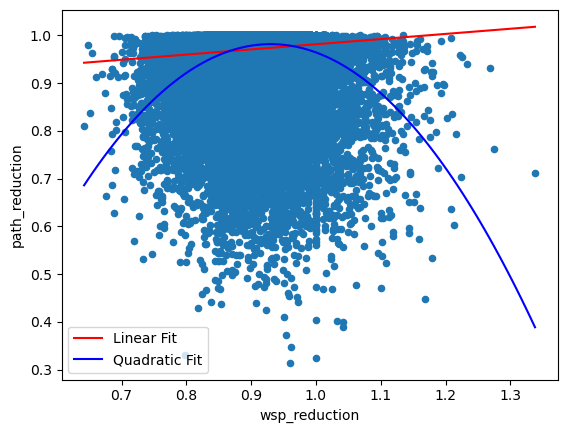

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_84375/1080431629.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


0.8734199003758074

In [68]:
reduction_df.plot.scatter("wsp_reduction", "path_reduction")
# Plot the first fitted model
x = np.linspace(reduction_df["wsp_reduction"].min(), reduction_df["wsp_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

In [69]:
path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(1, 'path_reduction'))
path_largest = reduction_df.groupby("parent").apply(lambda df: df.nlargest(1, 'path_reduction'))

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_84375/1782352281.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_smallest = reduction_df.groupby("parent").apply(lambda df: df.nsmallest(1, 'path_reduction'))
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_84375/1782352281.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  path_largest = reduction_df.groupby("parent").apply(lam

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_84375/2135297852.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_84375/2135297852.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     38.20
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           3.43e-17
Time:                        17:40:51   Log-Likelihood:                 4945.4
No. Observations:                5000   AIC:                            -9885.
Df Residuals:                    4997   BIC:                            -9865.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.4773      0.119      4.017      0.000       0.244       0.710
wsp_reduction             0.7789      0.258      3.022      0.003       0.274       1.284
I(wsp_reduction ** 2)    -0.4966      0.139     -3.561      0.000      -0.770      -0.223
==============================================================================
Omnibus:                      530.914   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              762.115
Skew:                          -0.817   Prob(JB):                    3.23e-166
Kurtosis:                       3.996   Cond. No.                         395.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

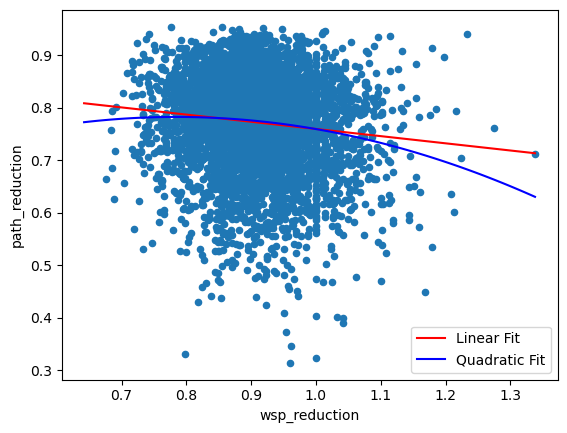

In [70]:
path_smallest.plot.scatter("wsp_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"].astype(float), sm.add_constant(path_smallest["wsp_reduction"].astype(float))).fit()

x = np.linspace(reduction_df["wsp_reduction"].min(), reduction_df["wsp_reduction"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

results2 = smf.ols(formula="path_reduction ~ wsp_reduction + I(wsp_reduction**2)", data=path_smallest).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')
plt.legend()

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     63.58
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           1.90e-15
Time:                        17:40:52   Log-Likelihood:                 4939.1
No. Observations:                5000   AIC:                            -9874.
Df Residuals:                    4998   BIC:                            -9861.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8967      0.016     57.307      0.000       0.866       0.927
wsp_reduction    -0.1369      0.017     -7.973      0.000      -0.171      -0.103
==============================================================================
Omnibus:                      532.668   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.718
Skew:                          -0.821   Prob(JB):                    3.94e-166
Kurtosis:                       3.979   Cond. No.                         24.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

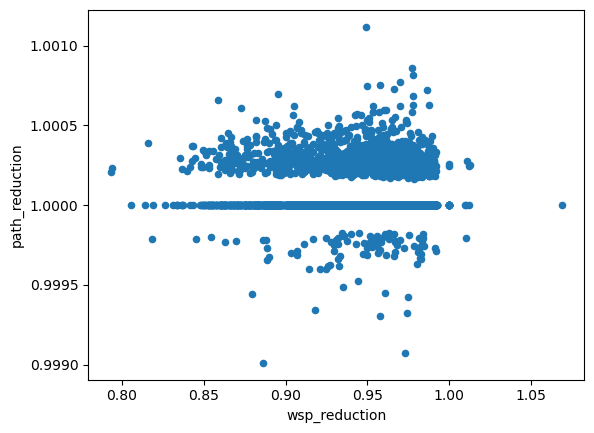

In [71]:
path_largest.plot.scatter("wsp_reduction", "path_reduction")
results = sm.OLS(path_smallest["path_reduction"].astype(float), sm.add_constant(path_smallest["wsp_reduction"].astype(float))).fit()
results.summary()

## How much does the wsps on a specific point actually matter

In [72]:
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                 4.848e+04
Date:                Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:40:52   Log-Likelihood:             1.5690e+05
No. Observations:              100000   AIC:                        -3.138e+05
Df Residuals:                   99998   BIC:                        -3.138e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8347      0.001   1295.011      0.000       0.833       0.836
point_specific_wsp     0.0099   4.48e-05    220.171      0.000       0.010       0.010
==============================================================================
Omnibus:                    58676.258   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           727209.234
Skew:                          -2.622   Prob(JB):                         0.00
Kurtosis:                      15.126   Cond. No.                         58.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         path_reduction   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                 3.850e+04
Date:                Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:40:52   Log-Likelihood:             1.6569e+05
No. Observations:              100000   AIC:                        -3.314e+05
Df Residuals:                   99997   BIC:                        -3.313e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.5725      0.002    288.873      0.000       0.569       0.576
point_specific_wsp             0.0521      0.000    169.452      0.000       0.051       0.053
I(point_specific_wsp ** 2)    -0.0016   1.14e-05   -138.599      0.000      -0.002      -0.002
==============================================================================
Omnibus:                    46790.070   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           544923.235
Skew:                          -1.956   Prob(JB):                         0.00
Kurtosis:                      13.746   Cond. No.                     3.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_84375/4134293542.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = results.params[0] + (results.params[1] * x)
/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_84375/4134293542.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2


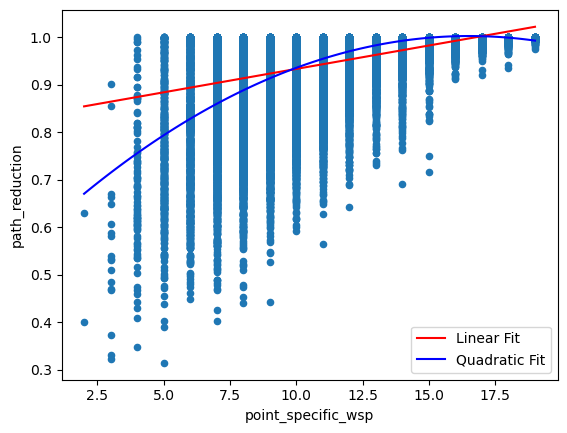

/var/folders/_t/4_m8pb3d3xs763zf2ztl10k40000gn/T/ipykernel_84375/4134293542.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0]


0.8346763652352036

In [74]:
reduction_df.plot.scatter("point_specific_wsp", "path_reduction")
# Plot the first fitted model
results = sm.OLS(reduction_df["path_reduction"], sm.add_constant(reduction_df["point_specific_wsp"])).fit()
x = np.linspace(reduction_df["point_specific_wsp"].min(), reduction_df["point_specific_wsp"].max(), 100)
y = results.params[0] + (results.params[1] * x)
plt.plot(x, y, color='red', label='Linear Fit')

# Plot the second fitted model
results2 = smf.ols(formula="path_reduction ~ point_specific_wsp + I(point_specific_wsp**2)", data=reduction_df).fit()
y2 = results2.params[0] + results2.params[1] * x + results2.params[2] * x**2
plt.plot(x, y2, color='blue', label='Quadratic Fit')

plt.legend()
plt.show()
results.params[0]

<Axes: >

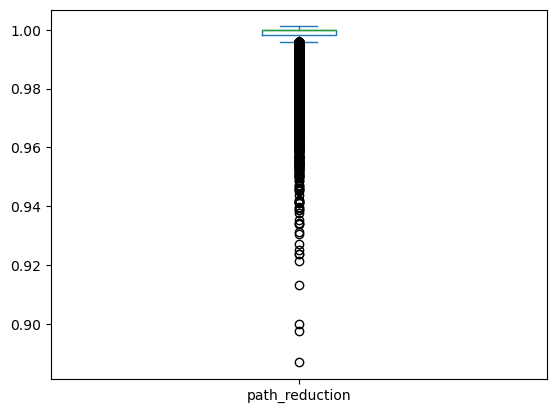

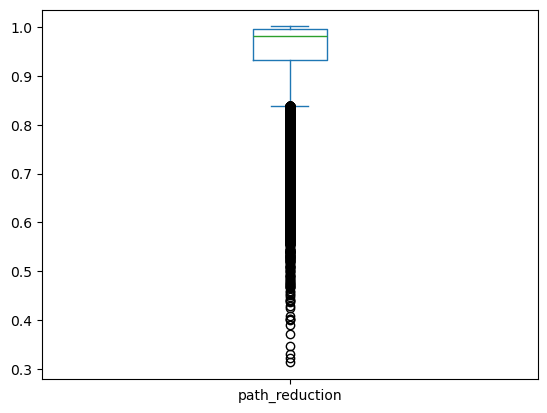

In [75]:
median = reduction_df['point_specific_wsp_weighted'].median()

reduction_df[reduction_df['point_specific_wsp_weighted'] > median].plot.box(y='path_reduction')
reduction_df[reduction_df['point_specific_wsp_weighted'] < median].plot.box(y='path_reduction')

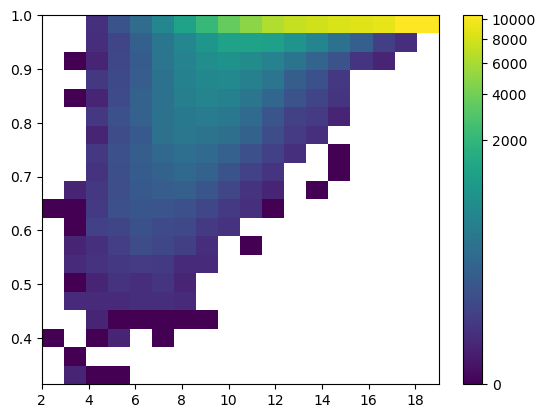

In [78]:
h = plt.hist2d(reduction_df["point_specific_wsp"], reduction_df["path_reduction"], bins=(18,20), cmin=1, norm=PowerNorm(0.25))
plt.colorbar(h[3])